# Code

In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import matplotlib.pyplot as pltimport 
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import numpy as np
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.kernel_approximation import RBFSampler
from collections import defaultdict
import scipy
from q_learning import *


In [2]:
def normalization(env, observation_examples):
    """
    Standardizes state observations by calculating their mean and variance.

    Args:
        env: Gym environment (used for consistency, though not directly required here).
        observation_examples: An array of random state observations sampled from the environment.

    Returns:
        sklearn.preprocessing.StandardScaler: A scaler fitted to the observations.
    """
    # Ensure the input is a 2D array
    observation_examples = np.array(observation_examples).reshape(-1, env.observation_space.shape[0])
    
    # Fit a scaler to normalize the data
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(observation_examples)
    
    return scaler


In [3]:
def featurizer_function(normalized_data, featureVecDim):
    """
    Generates a feature transformation pipeline using radial basis function (RBF) kernels.

    Args:
        normalized_data: An array of normalized state observations.
        featureVecDim: Target dimensionality for the feature transformation.

    Returns:
        sklearn.pipeline.FeatureUnion: A pipeline that transforms data into feature vectors.
    """
    # Create an RBF-based featurizer with multiple scales
    featurizer_vector = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=0.5, n_components=featureVecDim // 3)),
        ("rbf2", RBFSampler(gamma=0.25, n_components=featureVecDim // 3)),
        ("rbf3", RBFSampler(gamma=0.1, n_components=featureVecDim - 2 * (featureVecDim // 3)))
    ])
    
    # Ensure the normalized_data is a 2D array
    normalized_data = np.array(normalized_data).reshape(-1, normalized_data.shape[1])
    
    # Fit the featurizer to the normalized position data
    featurizer_vector.fit(normalized_data)
    
    return featurizer_vector

In [4]:
def scaler_val(state, scaler):
    # Chuẩn hóa toàn bộ vector trạng thái
    normalized_state = (state - scaler.mean_) / scaler.var_
    return normalized_state


In [5]:
def UniformRandomPolicyGenerator(nA):
    # nA = number of actions
    def urpg(state):
        return np.ones(nA, dtype=float)/nA
    return urpg

In [6]:
def RandomVectorGenerator(featureVecDim):
    return 2*np.random.rand(featureVecDim)-1

In [7]:
def max_dict(dictionary):
    v_max=max(dictionary.values())
    for key, value in dictionary.items():
        if value == v_max:
            return key

In [8]:
def e_greedy_policy(estimator, nA,epsilon):
    def policy_maker(observation):
        A=np.ones(nA, dtype=float)*epsilon/nA
        q_values=  estimator.predict(observation)
        best_action=np.argmax(q_values)
        A[best_action] += (1.0-epsilon)
        return A
    return policy_maker

In [9]:
def reward(alpha_vec, featurizer_vector, scaler):
    def reward_fn(state):
        # Normalize state bằng scaler, đảm bảo state có shape (1, n_features)
        normalized_state = scaler.transform(np.array(state).reshape(1, -1))

        # Áp dụng featurizer_vector trên state đã được chuẩn hóa
        features = featurizer_vector.transform(normalized_state)

        # Tính giá trị thưởng bằng dot product giữa alpha_vec và các đặc trưng
        return np.dot(alpha_vec, features[0])
    
    return reward_fn


In [10]:
def reward_plot(alpha_vec, featurizer_vector, scaler):
    x = np.linspace(-np.pi, np.pi, 1000)
    y = np.zeros(1000)
    i = 0

    for position in x:
        state = np.array([position, 0, 0, 0, 0, 0])  

        scaled_state = (state - scaler.mean_) / scaler.var_
        scaled_state = scaled_state.reshape(1, -1) 

        transformed_state = featurizer_vector.transform(scaled_state)

        y[i] = np.dot(alpha_vec, transformed_state[0])
        i += 1

    plt.plot(x, y, linewidth=2.0)
    plt.title("Reward Function")
    plt.xlabel("State (Position)")
    plt.ylabel("Reward")
    plt.show()


In [11]:
"""
Some experiments were done to smoothen up the alpha vector, if somebody would like to try.
I got some results,of them some were good but it resulted in diverging solutions many times.
"""
def smooth(y, box_pts=4):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def savitzky_golay(y, window_size=51, order=5, deriv=0, rate=1):

    import numpy as np
    from math import factorial
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [12]:
def ValueFunctionGenerator(env, alpha_vec, policy, featurizer_vec, scaler, featureVecDim, num_trajectories, discount_factor):
    """
    Calculates the value and value vector of the start state: V(s0).
    """
    v_basis = np.zeros(featureVecDim)
    episode = defaultdict(list) 
    for i in range(num_trajectories):
        state = env.reset()
        done = False
        for _ in range(200):    
            prob = policy(state)
            action = np.random.choice(np.arange(len(prob)), p=prob)
            new_observations = env.step(action)
            next_state = new_observations[0]
            done = new_observations[2]
            if done:
                break
            episode[i].append((state, action))
            state = next_state
        
        j = 0
        for state, action in episode[i]:
            scaled_state = scaler_val(state, scaler)
            # Đảm bảo scaled_state là mảng 2D
            scaled_state = np.array(scaled_state).reshape(1, -1)

            # scaled_state = np.atleast_2d(scaled_state)
            
            # transformed_state = featurizer_vec.transform(scaled_state)
            scaled_state = scaler_val(state, scaler)
            scaled_state = np.array(scaled_state).reshape(1, -1)  # Đảm bảo 2D array
            transformed_state = featurizer_vec.transform(scaled_state)

            
            v_basis += transformed_state[0] * (discount_factor)**j
            j += 1

    v_basis_net = v_basis / num_trajectories
    V = np.dot(alpha_vec, v_basis_net)
    return V, v_basis_net


In [13]:
def irl(env, alpha_vec,featurizer_vector, scaler, featurizer, normalized_data, featureVecDim, policy_dbe,num_trajectories=200, num_episodes=100, max_epoch=10, discount_factor=1, penalty_factor=2, epsilon_v=0.0):
    """
    The algorithm to learn a reward function given expert policy/trajectories.
    
    Args:
        env: Gym environment
        alpha_vec: The alpha vector (variable) to be learnt.
        featurizer_vector: The container for basis fuctions(RBF kernals in this case).
        scaler: Mean and variance of the state values.
        featurizer: The container used for generating expert trajectories.
        normalized_data: An array of 10000 normalized state::[position, velocity] values.
        featureVecDim: Dimension of ϕ vector.(feature vector/Basis vector)
        policy_dbe: "Demostration by expert" policy.==Expert policy
        num_trajectories: Expert trajectories taken under consideration
        num_episodes: Number of episodes for which the RL code is run. 
        max_iter: Maximum number of episodes
        penalty_factor: Refer the paper for more details
        epsilon_v: ϵ value for Epsilon greedy policy
        
    Returns:
        Reward Function R(s).
        Alpha Vector: α = [α0 α1 .. αn]
    """
    # Initializing Variables
    nP=0                                    # number of epochs
    V_vec = defaultdict(float)
    V_policy_basis = defaultdict(list)
    V_input = np.zeros(featureVecDim)
    
    # Calculating V* value for the best DBE policy that we already have.
    V_dbe, V_dbe_basis = ValueFunctionGenerator(env,alpha_vec, policy_dbe,featurizer_vector,scaler,featureVecDim, num_trajectories, discount_factor)
    print("-------------------------------")
    print("| V_dbe | ",V_dbe," |")
    print("-------------------------------")
    print("")
    
    # Iterating part of the code : new learnt policy with each new iteration
    
    while True:
        print("############################################################################")
        print("Starting epoch {} .... ".format(nP))
        print("Alpha_vec value at the start of the epoch = {}".format(alpha_vec)) 
        
        # Uniform Random policy
        if nP ==0:
            policy_ = UniformRandomPolicyGenerator(env.action_space.n)
        
        V_vec[nP], V_policy_basis[nP] = ValueFunctionGenerator(env,alpha_vec, policy_,featurizer_vector,scaler,featureVecDim,num_trajectories, discount_factor)
        print("New policy value based on previous alpha, V_vec[np] = {}".format(V_vec[nP]))
    
    
        # Linear Programming optimization
        print("_____________________________LP starts_______________________________")
        
        # nP_best: Iteration with the max value according to the present alpha_vec.
        nP_best = max_dict(V_vec)
        
        print("nP_best =", nP_best)
        print("nP_best_value based on old alpha =", V_vec[nP_best])
        print("DBE_value based on old alpha =", V_dbe)
        
        # if V_dbe - V_vec[nP] >= 0:
        #     V_input += V_policy_basis[nP] - V_dbe_basis
        # else:
        #     V_input += penalty_factor* (V_policy_basis[nP] - V_dbe_basis)
        
        # res = scipy.optimize.linprog(V_input, bounds=(-1,1), method="simplex")
        
        
        if V_dbe - V_vec[nP] >= 0:
            V_input += V_policy_basis[nP] - V_dbe_basis
        else:
            V_input += penalty_factor * (V_policy_basis[nP] - V_dbe_basis)

        # Duy trì V_input trong đúng bounds
        res = scipy.optimize.linprog(V_input, bounds=[(-1, 1)] * featureVecDim, method="simplex")

        
        print("**********LP results******************************************************")
        print("                       ")
        #print(res)
        print("new alpha_vec = ", res.x)
        print("                       ")
        print("**************************************************************************")
        
        alpha_vec_new = res.x
        
        # New V-dbe value based on new alpha
        V_dbe_new = np.dot(alpha_vec_new,V_dbe_basis)
        
        # Updating old values with new values
        alpha_vec = alpha_vec_new
        V_dbe = V_dbe_new
        
        # Editing v_vec values based on new alpha
        for i,list_ in V_policy_basis.items():
            V_vec[i] = np.dot(list_,alpha_vec)
        
        print("According to new alpha, V_dbe = ", V_dbe_new)
        print("New V_vec[max] in existing values", V_vec[max_dict(V_vec)])
        print("_________________________________________________________________________")
        print("Plotting reward function based on alpha_vec start value.....")
        
        reward_plot(alpha_vec, featurizer_vector,scaler)

        # Reinforcement learning using the learnt reward function to generate new policy
        
        print("Q learning starts..........")
        # Given the new alpha_vec, update the rewards function and find a new policy
        reward_fn = reward(alpha_vec,featurizer_vector,scaler)
        nP +=1
        
        estimator = Estimator(env,scaler,featurizer)
        min_iter_length = q_learning(env, estimator, reward_fn, num_episodes,print_ep_details=False) 
        policy_ = e_greedy_policy(estimator, env.action_space.n,epsilon_v)
        """
        ** For printing iterations with number of timesteps it took, set 
        {print_ep_details=True} in q_learning().Highly Suggested for starting analysis.
        """
    
        if nP > max_epoch:
            break
        print("############################################################################")
    
    
    return reward_fn, alpha_vec

100%|██████████| 1000/1000 [07:43<00:00,  2.16it/s]


___Plotting Learning Stats of the Agent____


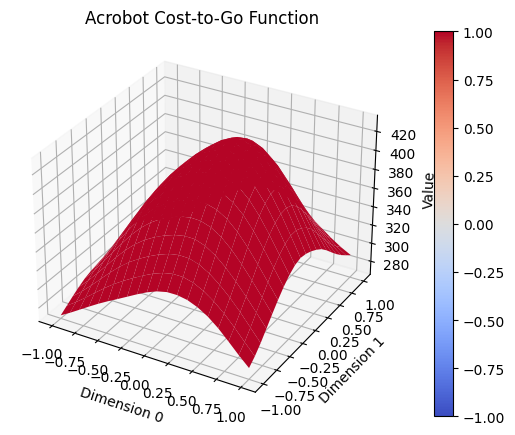

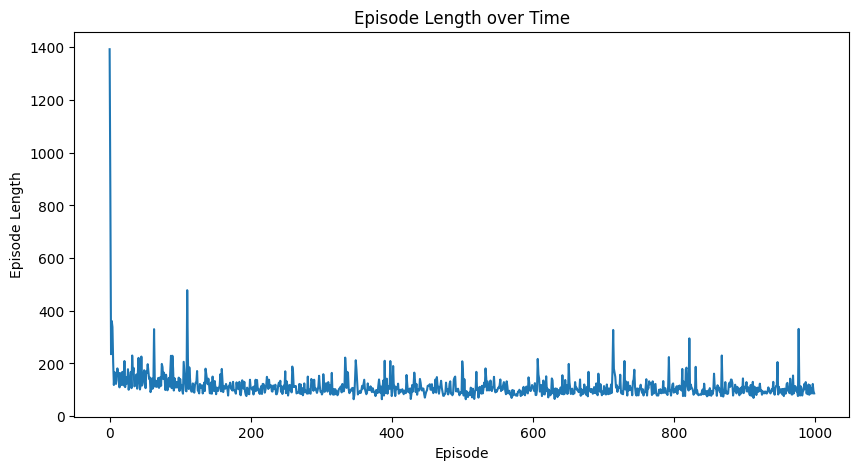

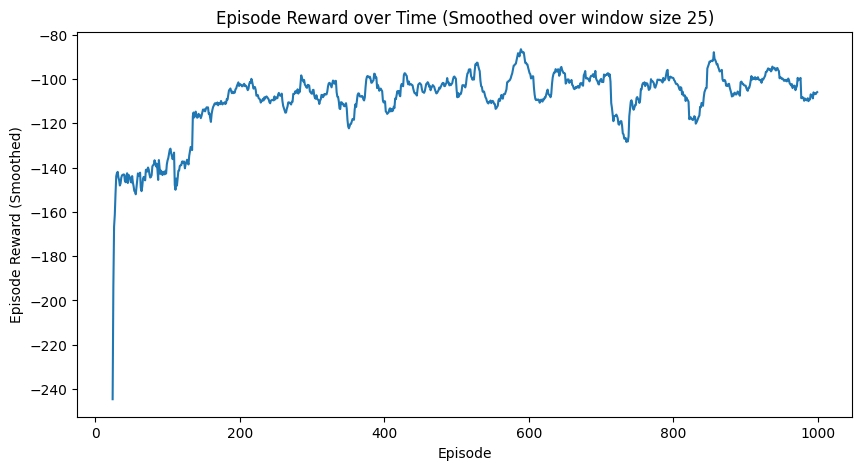

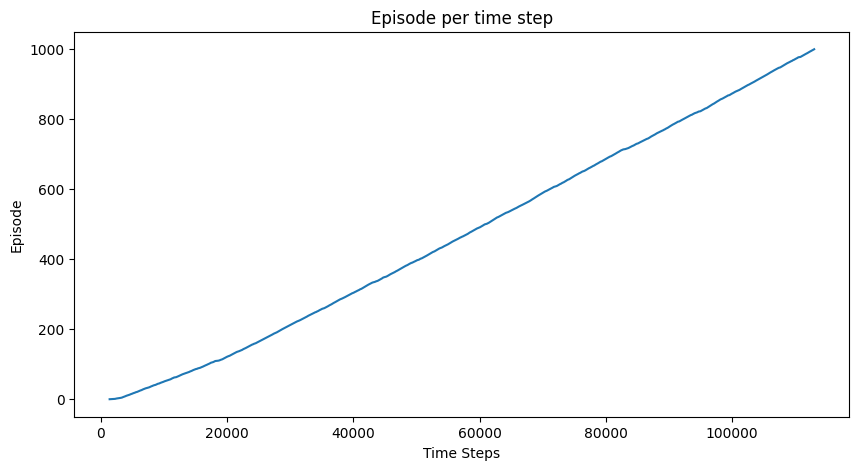

In [14]:
import gym
env = gym.make("Acrobot-v1").env  

# Global_variables
featureVecDim= 500

observation_examples = np.array([env.observation_space.sample() for _ in range(10000)])
scaler = normalization(env, observation_examples)
normalized_data = scaler.transform(observation_examples)

# Tạo featurizer
featurizer = featurizer_function(normalized_data, featureVecDim)

policy_dbe, estimator_dbe = policy_f(env, scaler, featurizer, print_ep_lens=False)


# IRL chính



In [15]:
# Basis functions Container / Feature Vector Container
featurizer_vector = featurizer_function(normalized_data, featureVecDim)
alpha_vec = RandomVectorGenerator(featureVecDim)

-------------------------------
| V_dbe |  12.427394820737586  |
-------------------------------

############################################################################
Starting epoch 0 .... 
Alpha_vec value at the start of the epoch = [ 0.13844668 -0.07318044  0.19835566 -0.33472373  0.37656164 -0.61654074
 -0.30081462 -0.80248465 -0.94973725 -0.07404854  0.32507447 -0.52583951
  0.21074785  0.85695802  0.90210734  0.63946287  0.6315846   0.455971
  0.26150866 -0.28169142  0.52229362 -0.07627681  0.42223166 -0.70873698
 -0.93983412 -0.85473796  0.86623905 -0.84739286 -0.24778945 -0.71957463
 -0.3542216   0.33107927  0.09856466 -0.75275241 -0.37733404 -0.19577951
 -0.37712114 -0.28776539  0.38375746  0.61829892 -0.34751736 -0.86490621
 -0.40505909  0.63000673 -0.45194962  0.69442512 -0.31733657 -0.37247425
 -0.85887046  0.11949046  0.69827957  0.82379283 -0.42468161  0.65374665
 -0.66363523  0.74815063 -0.371388    0.27739772  0.60867515  0.20423811
 -0.38982933 -0.17176574 -0.75

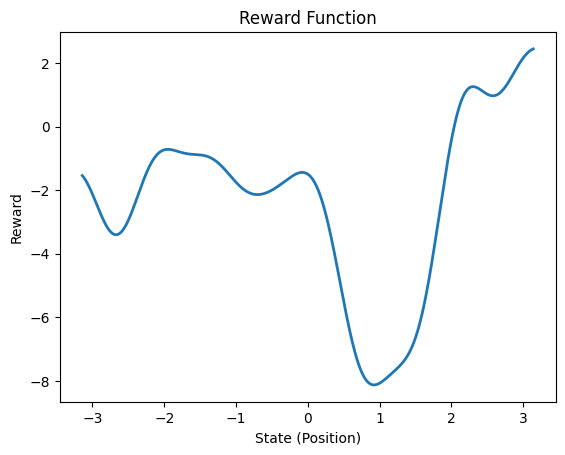

Q learning starts..........


100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


############################################################################
############################################################################
Starting epoch 1 .... 
Alpha_vec value at the start of the epoch = [-1. -1.  1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1. -1. -1.  1. -1. -1.
  1.  1. -1. -1. -1.  1. -1.  1. -1.  1.  1. -1. -1. -1.  1. -1.  1.  1.
  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1. -1.  1. -1.  1.  1. -1.
  1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1. -1.  1.
  1.  1. -1. -1. -1.  1.  1. -1. -1.  1. -1.  1. -1.  1. -1. -1.  1.  1.
  1.  1. -1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1.  1. -1.  1.
 -1. -1. -1.  1. -1. -1.  1.  1. -1.  1. -1. -1. -1.  1. -1. -1. -1.  1.
 -1. -1.  1. -1. -1. -1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1. -1.
  1.  1. -1.  1.  1.  1.  1.  1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.
  1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1.
 -1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1. 

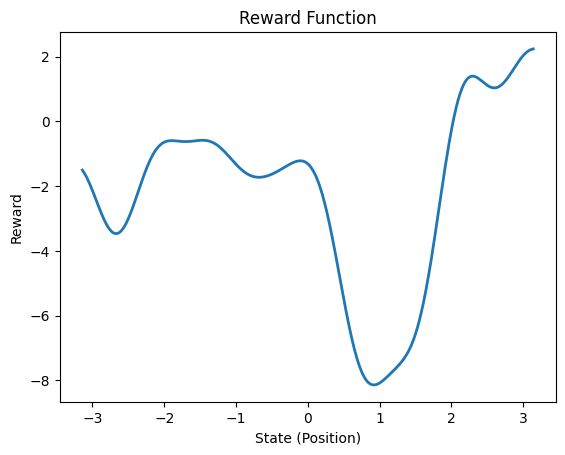

Q learning starts..........


100%|██████████| 100/100 [01:17<00:00,  1.28it/s]


############################################################################
############################################################################
Starting epoch 2 .... 
Alpha_vec value at the start of the epoch = [-1. -1.  1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1. -1. -1.  1. -1. -1.
  1.  1. -1. -1. -1.  1. -1.  1. -1.  1.  1. -1. -1. -1.  1. -1.  1.  1.
  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1. -1.  1. -1.  1.  1. -1.
  1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1. -1.  1.
  1.  1. -1. -1. -1.  1.  1. -1. -1.  1. -1.  1. -1.  1. -1. -1.  1.  1.
  1.  1. -1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1.  1. -1.  1.
 -1. -1. -1.  1. -1. -1.  1.  1. -1.  1. -1. -1. -1.  1. -1. -1. -1.  1.
 -1. -1.  1. -1. -1. -1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1. -1.
  1.  1. -1.  1.  1.  1.  1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1.  1.
  1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1.
 -1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1. 

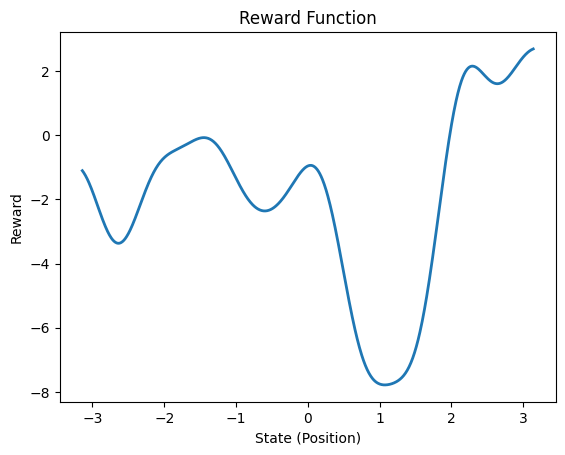

Q learning starts..........


100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


############################################################################
############################################################################
Starting epoch 3 .... 
Alpha_vec value at the start of the epoch = [-1. -1.  1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1. -1. -1.  1. -1. -1.
  1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1. -1.  1. -1.  1. -1.  1.  1.
  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1. -1.  1.  1.  1.  1. -1.
  1.  1. -1.  1. -1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1. -1.  1.
  1.  1. -1. -1. -1.  1.  1. -1. -1.  1. -1.  1. -1.  1. -1. -1.  1.  1.
  1.  1. -1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1.  1. -1.  1.
 -1. -1. -1.  1. -1. -1.  1.  1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1.  1.  1. -1. -1. -1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1. -1.
  1.  1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1.  1.
  1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1. -1.  1.  1.  1.  1. -1.
 -1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1. 

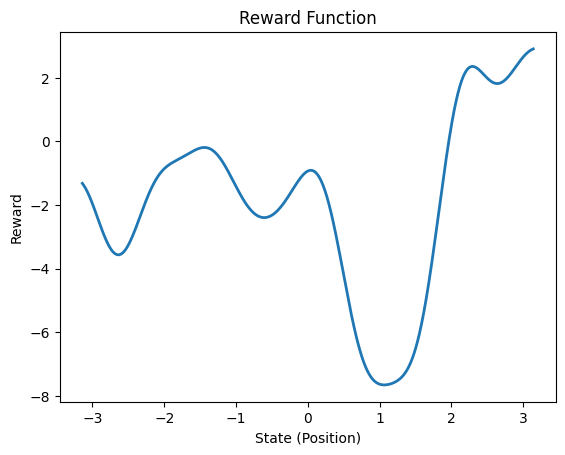

Q learning starts..........


100%|██████████| 100/100 [01:42<00:00,  1.02s/it]


############################################################################
############################################################################
Starting epoch 4 .... 
Alpha_vec value at the start of the epoch = [-1. -1.  1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1. -1. -1.  1. -1. -1.
  1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1. -1.  1. -1.  1. -1.  1.  1.
  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1. -1.  1.  1.  1.  1. -1.
  1.  1. -1.  1. -1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1. -1.  1.
  1.  1. -1. -1. -1.  1.  1. -1. -1.  1. -1.  1. -1.  1. -1. -1.  1.  1.
  1.  1. -1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1.  1. -1.  1.
 -1. -1. -1.  1. -1. -1.  1.  1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1.  1.  1. -1. -1. -1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1. -1.
  1.  1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1.  1.
  1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1. -1.  1.  1.  1.  1. -1.
 -1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1. 

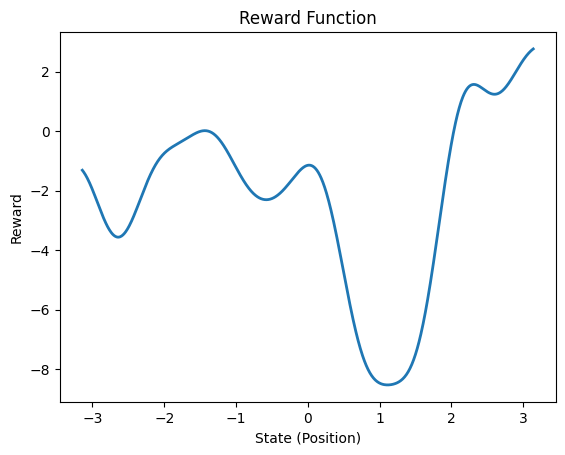

Q learning starts..........


100%|██████████| 100/100 [00:59<00:00,  1.67it/s]


############################################################################
############################################################################
Starting epoch 5 .... 
Alpha_vec value at the start of the epoch = [-1. -1.  1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1. -1. -1.  1. -1. -1.
  1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1. -1.  1. -1.  1. -1.  1.  1.
  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1. -1.  1.  1.  1.  1. -1.
  1.  1. -1.  1. -1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1. -1.  1.
  1.  1. -1. -1. -1.  1.  1. -1. -1.  1. -1.  1. -1. -1. -1. -1.  1.  1.
  1. -1. -1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1.  1. -1.  1.
 -1. -1. -1.  1. -1. -1.  1.  1. -1.  1. -1. -1. -1. -1. -1. -1. -1.  1.
 -1.  1.  1. -1. -1. -1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1. -1.
  1.  1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1.  1.
  1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1. -1.  1.  1.  1.  1.  1.
 -1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1. 

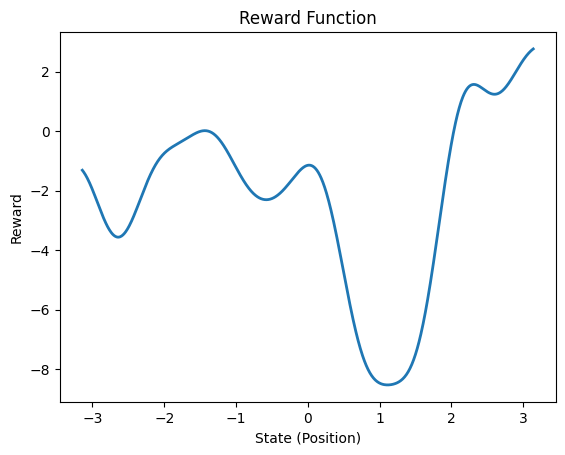

Q learning starts..........


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


############################################################################
############################################################################
Starting epoch 6 .... 
Alpha_vec value at the start of the epoch = [-1. -1.  1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1. -1. -1.  1. -1. -1.
  1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1. -1.  1. -1.  1. -1.  1.  1.
  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1. -1.  1.  1.  1.  1. -1.
  1.  1. -1.  1. -1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1. -1.  1.
  1.  1. -1. -1. -1.  1.  1. -1. -1.  1. -1.  1. -1. -1. -1. -1.  1.  1.
  1. -1. -1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1.  1. -1.  1.
 -1. -1. -1.  1. -1. -1.  1.  1. -1.  1. -1. -1. -1. -1. -1. -1. -1.  1.
 -1.  1.  1. -1. -1. -1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1. -1.
  1.  1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1.  1.
  1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1. -1.  1.  1.  1.  1.  1.
 -1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1. 

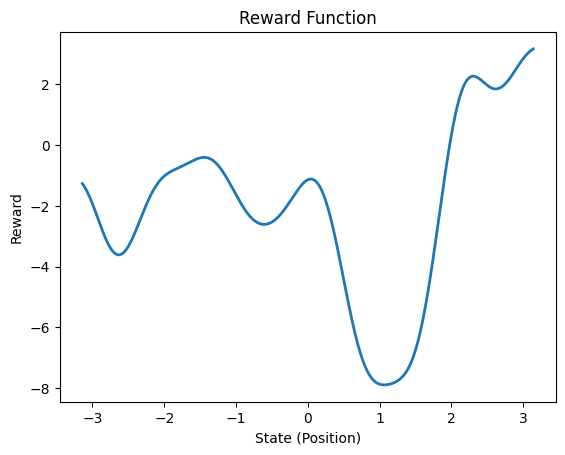

Q learning starts..........


100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


############################################################################
############################################################################
Starting epoch 7 .... 
Alpha_vec value at the start of the epoch = [-1. -1.  1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1. -1. -1.  1.  1. -1.
  1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1. -1.  1. -1.  1. -1.  1.  1.
  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1. -1.  1.  1.  1.  1. -1.
  1.  1. -1.  1. -1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1. -1.  1.
  1.  1. -1. -1. -1.  1.  1. -1. -1.  1. -1.  1. -1. -1. -1. -1.  1.  1.
  1. -1. -1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1.  1. -1.  1.
 -1. -1. -1.  1. -1. -1.  1.  1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1.  1.  1. -1. -1. -1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1. -1.
  1.  1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1.  1.
  1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1. -1.  1.  1.  1.  1.  1.
 -1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1. 

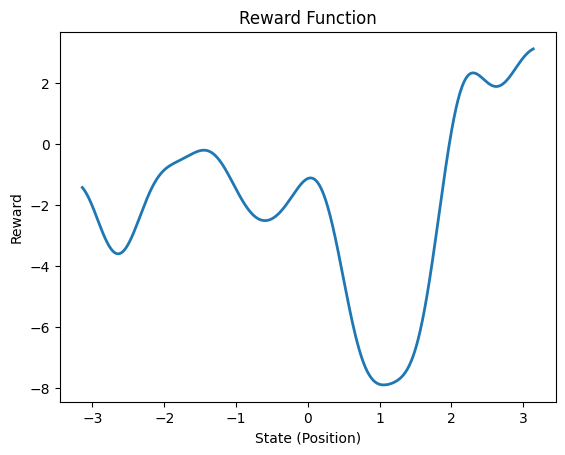

Q learning starts..........


100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


############################################################################
############################################################################
Starting epoch 8 .... 
Alpha_vec value at the start of the epoch = [-1. -1.  1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1. -1. -1.  1. -1. -1.
  1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1. -1.  1. -1.  1. -1.  1.  1.
  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1. -1.  1.  1.  1.  1. -1.
  1.  1. -1.  1. -1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1. -1.  1.
  1.  1. -1. -1. -1.  1.  1. -1. -1.  1. -1.  1. -1. -1. -1. -1.  1.  1.
  1.  1. -1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1.  1. -1.  1.
 -1. -1. -1.  1. -1. -1.  1.  1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1.  1.  1. -1. -1. -1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1. -1.
  1.  1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1.  1.
  1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1. -1.  1.  1.  1.  1.  1.
 -1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1. 

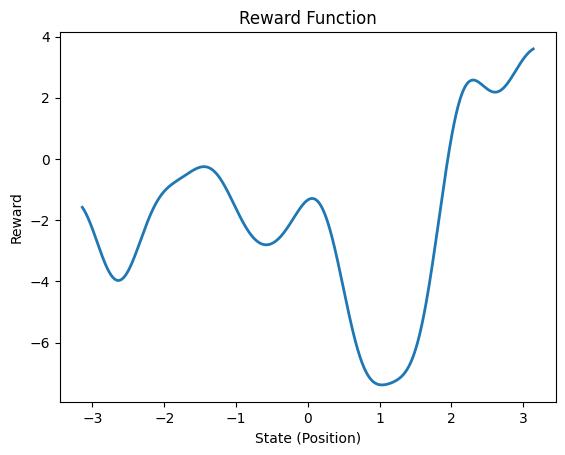

Q learning starts..........


100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


############################################################################
############################################################################
Starting epoch 9 .... 
Alpha_vec value at the start of the epoch = [-1. -1.  1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1. -1. -1.  1.  1. -1.
  1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1. -1.  1. -1.  1. -1.  1.  1.
  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1. -1.  1.  1.  1.  1. -1.
  1.  1. -1.  1. -1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1. -1.  1.
  1.  1. -1. -1. -1.  1.  1. -1. -1.  1. -1.  1. -1.  1. -1. -1.  1.  1.
  1.  1. -1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1.  1. -1.  1.
 -1. -1. -1.  1. -1. -1.  1.  1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1.  1.  1. -1. -1. -1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1. -1.
  1.  1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1.  1.
  1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1. -1.  1.  1.  1.  1.  1.
 -1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1. 

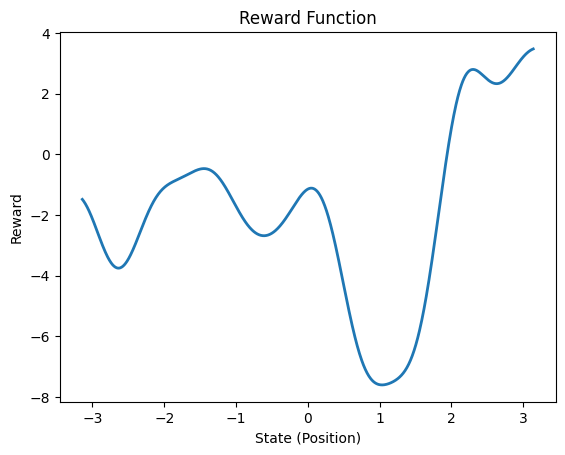

Q learning starts..........


100%|██████████| 100/100 [01:28<00:00,  1.14it/s]


############################################################################
############################################################################
Starting epoch 10 .... 
Alpha_vec value at the start of the epoch = [-1. -1.  1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1. -1. -1.  1.  1. -1.
  1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1. -1.  1. -1.  1. -1.  1.  1.
  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1. -1.  1.  1.  1.  1. -1.
  1.  1. -1.  1. -1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1. -1.  1.
  1.  1. -1. -1. -1.  1.  1. -1. -1.  1. -1.  1. -1.  1. -1. -1.  1.  1.
  1.  1. -1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1.  1. -1.  1.
 -1. -1. -1.  1. -1. -1.  1.  1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1.  1.  1. -1. -1. -1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1. -1.
  1.  1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1.  1.
  1. -1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1. -1.  1.  1.  1.  1.  1.
 -1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1.

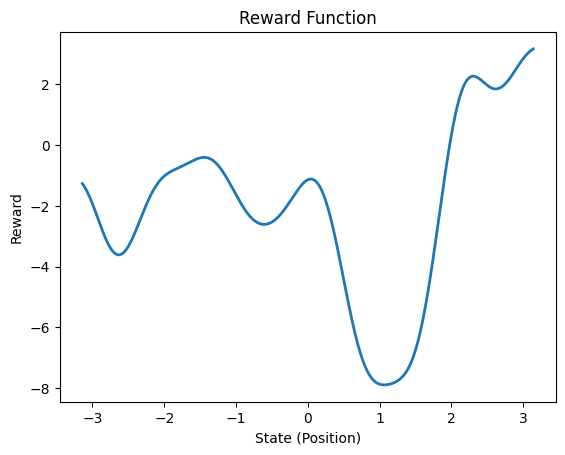

Q learning starts..........


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


In [16]:
reward_fn, alpha_vec = irl(env, alpha_vec, featurizer_vector, scaler, featurizer,
                           normalized_data, featureVecDim, policy_dbe)

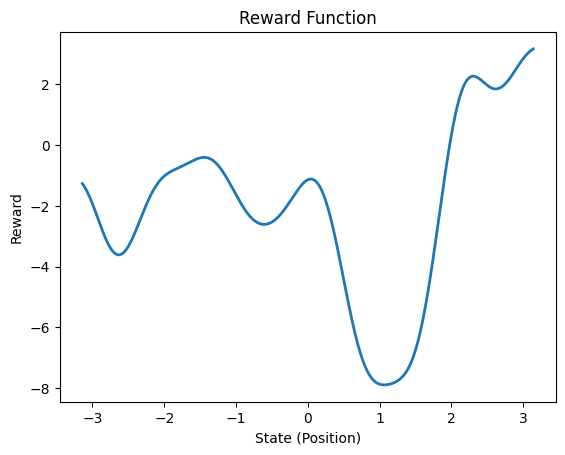

Q-learning starts:


100%|██████████| 200/200 [24:58<00:00,  7.49s/it]


Final results in graphs and 3D visualization:


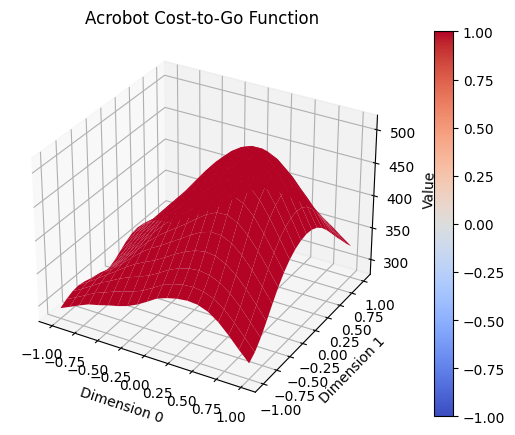

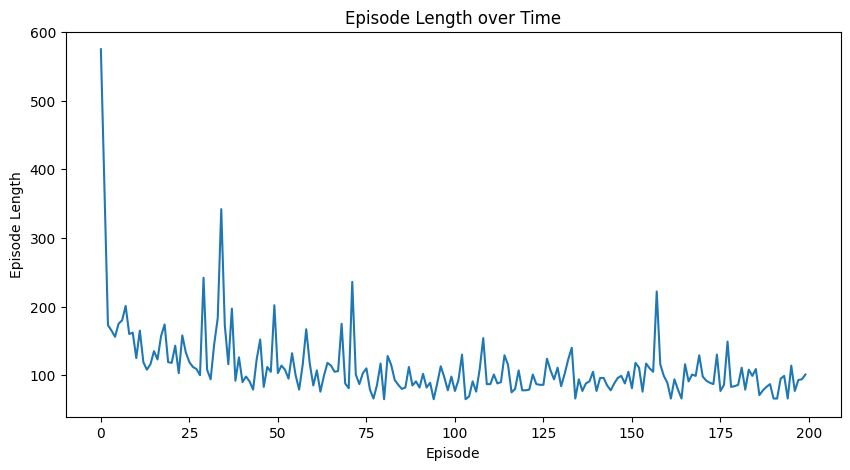

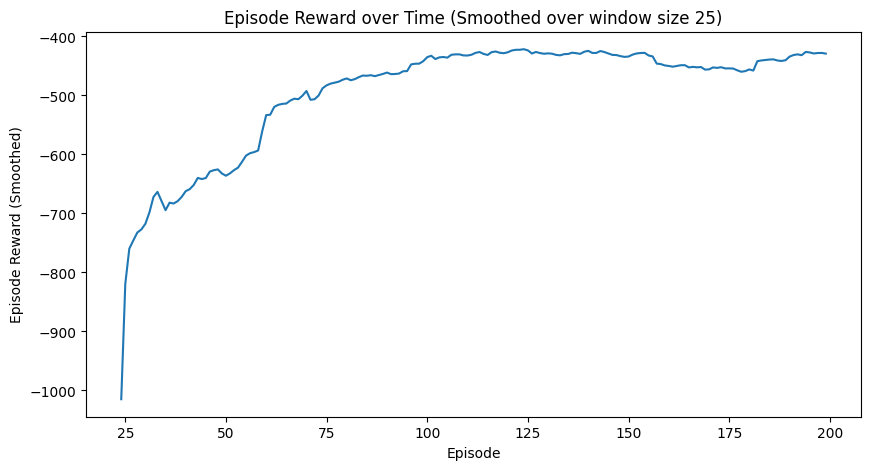

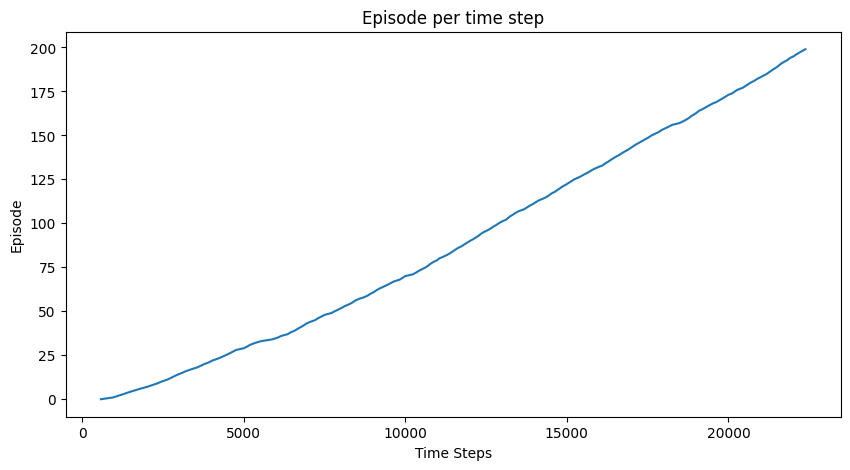

(<Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>)

In [17]:
"""
Code Block generating stats for agent trained through learnt reward function.
"""
estimator_f = Estimator(env, scaler, featurizer)
reward_plot(alpha_vec,featurizer_vector,scaler)
print("Q-learning starts:")
"""
** For printing iterations with number of timesteps required, set {print_ep_details=True} in q_learning_testing_rewards().
Highly Suggested for starting analysis.
"""
success = q_learning_testing_rewards(env, estimator_f, reward_fn , num_episodes=200,render=True,ep_details=False)

print("Final results in graphs and 3D visualization:")
plotting.plot_cost_to_go_acrobot(env, estimator_f, scaler)
plotting.plot_episode_stats(success, smoothing_window=25)

100%|██████████| 100/100 [10:13<00:00,  6.13s/it]


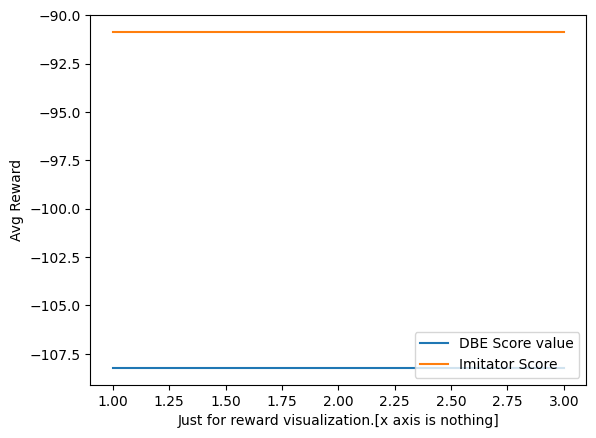

Expert policy score   |  -108.23
Imitator policy score |  -90.86


In [18]:
a,b = compare_results(env,estimator_f,estimator_dbe,num_test_trajs=100,epsilon_test=0.0)

# Comments on the Final results

- The reward function learnt may be different everytime. The reason is the issue of degeneracy & is clearly explained in the [IRL](https://ai.stanford.edu/~ang/papers/icml00-irl.pdf) paper. 


- The Ideal results that is expected is `Expert policy score >= Imitator Policy score`. The **expert score** ranges between `[-150,-100]` and the **imitator score** must be as near to the Expert score indicating it learnt as great the imitator. But, that's not the case everytime. There are cases where:
    - Imitator Score is quite worse compared to Expert Score.
    - Imitator score is better than Expert Score.
    - Expert score is lower than -180.
    - Reward function learning diverges. (very rare but happens with some hyperparameter combinations)


- The main reason behind the exception cases is the fact that the starting position of the car is random between [-0.6,-0.4], which causes _variations_ in the trajectory data. As we used a linear approximator, its not good a function approximator compared to neural networks. The two ways to make sure such cases occur the least are:
    - Change the random start state line in the environment code. (Optional - To be clear, all results were generated on non-edited mountain car env)
    - Increase the value of `num_trajectories`. (Optimal observed was 10)

# Further Work:

- Need to use `l1 norm` in the LP optimization in addition with the original optimization. It was explained in the paper that it may help solve the key issue of degeneracy, the existance of large set of reward functions for which the observed policy is optimal.


- Need to normalize learnt reward function beetween `[-1,0]`. I believe that bounding the reward function may help in better learning of reward function.